In [59]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import scipy
import scipy.stats as st
from pylab import cm
from matplotlib import colors as mcol

from netCDF4 import Dataset as NetCDFFile

In [9]:
mk_df = pd.read_csv('results-mk-lc.txt', sep=',', index_col='site')
att_df = pd.read_csv('attributes_with_NWM_LSTM_PP.csv', sep=',', index_col='gauge_id')
# Add the basin ID as a 8 element string with a leading zero if neccessary
basin_id_str = []
for a in att_df.index.values:
    basin_id_str.append(str(a).zfill(8))
att_df['basin_id_str'] = basin_id_str

In [10]:
# Get the hydrologic units for each basin.
with open('usgs_site_info.csv', 'r') as f:
    usgs_sites = pd.read_csv(f, skiprows=24, index_col='site_no')
usgs_idx_int = []
for idx in usgs_sites.index.values:
    usgs_idx_int.append(int(idx))
usgs_sites.reindex(usgs_idx_int)
usgs_sites = usgs_sites.reindex(usgs_idx_int)
basin_hydro_unit = []
for b in att_df.basin_id_str.values:
    huc_cd = usgs_sites.loc[int(b),'huc_cd']
    hu = '{:08d}'.format(huc_cd)
    basin_hydro_unit.append(hu[0:2])
att_df['basin_hydro_unit'] = basin_hydro_unit

In [11]:
df = mk_df.join(att_df)

In [52]:
df = df.dropna()

In [17]:
def do_gpr(X,y):
    kf = KFold(n_splits=10, shuffle=True)
    kf.get_n_splits(X)
    r2_list = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
        gpr = GaussianProcessRegressor(kernel=kernel, \
                                       n_restarts_optimizer=15, \
                                       alpha=0.1, normalize_y=True)
        gpr.fit(X_train, y_train)

        y_hat = gpr.predict(X_test, return_std=False) 
        rmse = np.sqrt(np.mean((y_test - y_hat)**2))
        r2 = r2_score(y_test, y_hat)
        r2_list.append(r2)
        plt.scatter(y_hat,y_test)
        print(r2)
    print('Average r-squared value = {:.2f}'.format(np.mean(r2_list)))

0.5351904232177163
0.5969457846126318
0.380194983789077
0.34245463780071883
0.5046812199061353
0.3132286850770619
0.524389753168419
0.30000423310038293
0.28962253173803887
0.55100130243129
Average r-squared value = 0.43


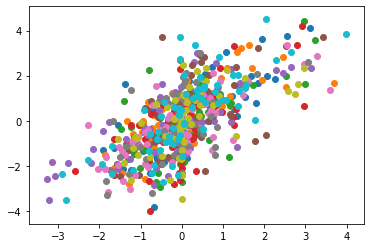

In [42]:
X=np.array(mk_df.loc[:,['lat','lon']])
y=np.array(mk_df['Q/P'])
do_gpr(X,y)

0.10886117899041226
-0.05852034027297992
0.18491965205438388
0.07174402647430833
-0.031046629577112572
0.04787135749013782
-0.06800458603712989
0.05940355125479124
-0.006990007873606707
0.15315439902636385
Average r-squared value = 0.05


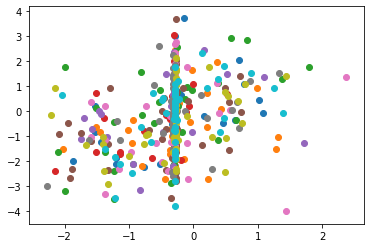

In [36]:
d_drop = df.loc[:,['basin_hydro_unit','tree_canopy_cover', 'impervious']]
#d_drop = d_drop.loc[d_drop['basin_hydro_unit'] == '19']
X=np.array(d_drop)
y=np.array(mk_df['Q/P'])
do_gpr(X,y)

In [38]:
df.columns.values

array(['potential_evaporation', 'skin_temperature',
       'soil_temperature_level_1',
       'evaporation_from_vegetation_transpiration', 'lat', 'lon', 'P',
       'Q', 'P-Q', 'Q/P', '(P-Q)/P', 'tree_canopy_cover', 'impervious',
       'q_mean', 'runoff_ratio', 'slope_fdc', 'baseflow_index',
       'stream_elas', 'q5', 'q95', 'high_q_freq', 'high_q_dur',
       'low_q_freq', 'low_q_dur', 'hfd_mean', 'geol_1st_class',
       'glim_1st_class_frac', 'carbonate_rocks_frac', 'geol_porostiy',
       'geol_permeability', 'p_mean', 'pet_mean', 'p_seasonality',
       'frac_snow', 'aridity', 'high_prec_freq', 'high_prec_dur',
       'low_prec_freq', 'low_prec_dur', 'low_prec_timing', 'gauge_lat',
       'gauge_lon', 'elev_mean', 'area_gages2', 'area_geospa_fabric',
       'soil_depth_pelletier', 'soil_depth_statsgo', 'max_water_content',
       'sand_frac', 'silt_frac', 'clay_frac', 'other_frac', 'frac_forest',
       'lai_max', 'gvf_max', 'dom_land_cover_frac', 'dom_land_cover',
       'basin

0.0035678096034362783
-0.09560495564232219
-0.002411197538052523
0.01031854235467744
-0.050412268236716073
0.04558544714948232
0.006818522771463109
0.04256804444445583
-0.05437329522687584
-0.014381247645461004
Average r-squared value = -0.01


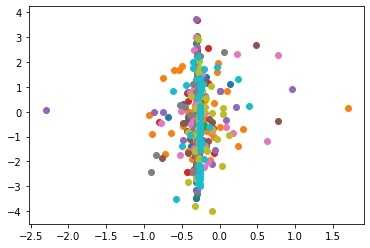

In [41]:
d_drop = df.loc[:,['lat', 'lon',
    'potential_evaporation', 'skin_temperature','soil_temperature_level_1','evaporation_from_vegetation_transpiration',
    'geol_1st_class','glim_1st_class_frac', 'carbonate_rocks_frac', 'geol_porostiy','geol_permeability',
    'elev_mean', 'area_gages2', 'area_geospa_fabric',
       'soil_depth_pelletier', 'soil_depth_statsgo', 'max_water_content',
       'sand_frac', 'silt_frac', 'clay_frac', 'other_frac', 'frac_forest',
       'lai_max', 'gvf_max', 'dom_land_cover_frac', 'dom_land_cover',
       'basin_hydro_unit' ]]
#d_drop = d_drop.loc[d_drop['basin_hydro_unit'] == '19']
X=np.array(d_drop)
y=np.array(mk_df['Q/P'])
do_gpr(X,y)

0.11839938890512836
0.1293265676507318
0.18605093550663365
0.34524321822820536
0.4617028076640707
0.2707160525143514
0.29561935782766713
0.29933348555131
0.4430283597378456
0.4378696639174504
Average r-squared value = 0.30


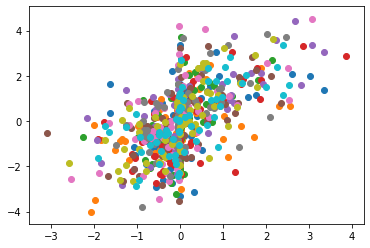

In [20]:
d_drop = mk_df.loc[:,['lat', 'lon', 'tree_canopy_cover', 'impervious']].dropna()
X=np.array(d_drop)
y=np.array(mk_df['Q/P'])
do_gpr(X,y)

0.37936251806030086
0.3609581841222794
0.06126252155705059
0.2701204600629131
0.34803597214992543
0.32584079470564475
0.2704849627853574
0.35862671221031694
0.4449499344806116
0.46518200389042075
Average r-squared value = 0.33


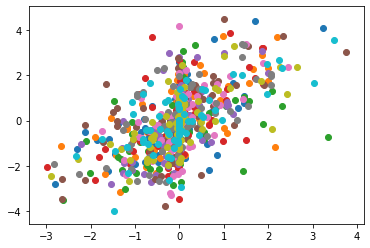

In [15]:
X=np.array(mk_df.loc[:,['potential_evaporation',
                          'skin_temperature',
                          'soil_temperature_level_1',
                          'evaporation_from_vegetation_transpiration']])
y=np.array(mk_df['Q/P'])
do_gpr(X,y)

0.4038400865895829
0.5492021846087242
0.6746249465846432
0.5253734386236817
0.4434409481499254
0.4555912651137095
0.48341047309175467
0.4759986654788092
0.42689316737890504
0.5173875682035747
Average r-squared value = 0.50


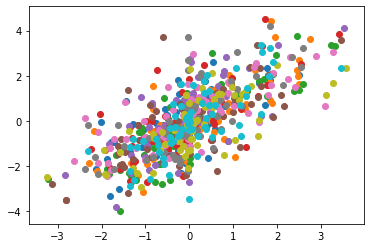

In [43]:
X=np.array(mk_df.loc[:,['potential_evaporation',
                          'skin_temperature',
                          'soil_temperature_level_1',
                          'evaporation_from_vegetation_transpiration',
                          'lat','lon']].dropna())
y=np.array(mk_df['Q/P'])
do_gpr(X,y)

0.3328213297004282
0.28130156480513624
0.45192932790926754
0.2123779193472587
0.3950914618200124
0.3429372621244705
0.38499580087806107
0.35128451798816474
0.4599720578398103
0.1936492587228663
Average r-squared value = 0.34


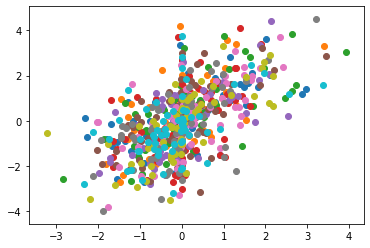

In [18]:
X=np.array(mk_df.loc[:,['potential_evaporation',
                          'skin_temperature',
                          'soil_temperature_level_1',
                          'evaporation_from_vegetation_transpiration',
                          'lat','lon',
                          'tree_canopy_cover', 'impervious']].dropna())
y=np.array(mk_df['Q/P'])
do_gpr(X,y)

-1.0120014003739137
-1.5127161848994777
-1.0830897262245394
-0.11789865372869213
-1.437854813322026
-1.641951871713906
-1.6858509456713664
-0.6890791347469909
-0.34695096033221073
-1.3050957473043598
Average r-squared value = -1.08


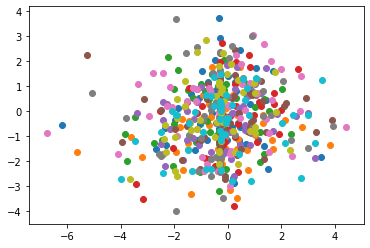

In [44]:
X=np.array(df.loc[:,['lstmnwm-lstm', 'lstmnwm-nwm']])
y=np.array(mk_df['Q/P'])
do_gpr(X,y)

In [74]:
# Random Forest Regression in a K-fold loop
def cross_val_rf(X,y,feature_list,kf,ynormal=False,
                 n_estimators=10,random_state=42,
                 criterion='mse', min_samples_leaf=1, min_samples_split=2, max_depth=None,
                 min_weight_fraction_leaf=0, feature_list_short=[]):

    if len(feature_list_short) > 1:
        index_labs = feature_list_short
    else:
        index_labs = feature_list
    feature_importances = pd.DataFrame(index=index_labs, columns=['total_importance'])
    for iF, F in enumerate(feature_importances.index.values):
        feature_importances.loc[F, 'total_importance'] = 0
    
    rmse_list = []
    r2_list = []
    y_hat_list = []
    y_hat_indx_list = []
    
    fig, ax = plt.subplots(figsize=(6.5,4.02))
    grid = plt.GridSpec(1, 3, wspace=0.33333)
    plt.subplot(grid[0, 0:2])
    for train_index, test_index in kf.split(X):
                
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        rf = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state,
                                  criterion=criterion, min_samples_leaf=min_samples_leaf,
                                  min_samples_split=min_samples_split, max_depth=max_depth,
                                  min_weight_fraction_leaf=min_weight_fraction_leaf)
        rf.fit(X_train, y_train);
        y_hat = rf.predict(X_test)

        # Get numerical feature importances
        importances = list(rf.feature_importances_)
        for iF, F in enumerate(feature_importances.index.values):
            feature_importances.loc[F, 'total_importance'] += importances[iF]
        
        rmse = np.sqrt(np.mean(np.power((y_test - y_hat),2)))
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_test, y_hat)
        r2 = r_value**2        
        plt.scatter(y_test,y_hat)
        
        rmse_list.append(rmse)
        r2_list.append(r2)
        y_hat_list.extend(y_hat)
        y_hat_indx_list.extend(test_index)
    
    feature_importances.loc[:, 'total_importance'] = feature_importances.loc[:, 'total_importance'] / \
                                                     kf.get_n_splits()

    #plt.title("Cross validation results with {:2d} splits".format(kf.get_n_splits()))
    plt.xlabel("true target values")
    plt.ylabel("predicted values")

    y_hat_all = sort_list(y_hat_list, y_hat_indx_list)
    
    overall_rmse = np.sqrt(np.mean(np.power((y - y_hat_all),2)))
    slope, intercept, overall_r_value, _, _ = scipy.stats.linregress(y, y_hat_all)
    overall_r2_value = overall_r_value**2
    print('Overall rmse for the out-of-sample predictions: {:.2f}'.format(overall_rmse))
    print('Overall r^2 for the out-of-sample predictions: {:.2f}'.format(overall_r_value**2))
    print("RMSE Value stats for cross validation")
    print_stats(rmse_list)
    print("R-squared Value stats for cross validation")
    print_stats(r2_list)
    x=np.linspace(np.min(y), np.max(y), num=2)
    omax = np.max([np.max(y), np.max(y_hat_all)])
    omin = np.min([np.min(y), np.min(y_hat_all)])
    plt.xlim([omin,omax])
    plt.ylim([omin,omax])
    plt.plot(x, x*slope+intercept)
    plt.grid()
    
    plt.subplot(grid[0, 2])
    feature_importances.sort_values('total_importance', ascending=False).iloc[0:5].plot.bar(ax = plt.gca())
    plt.legend([])
    plt.ylabel('feature importance')
    plt.xticks(rotation=90)
    plt.grid()

    grid.tight_layout(fig)
    plt.show()
    plt.close()    

    return y_hat_all, overall_rmse, overall_r2_value, feature_importances

In [75]:
# Set the training and targets.
def set_X_y(df, regressor_attributes, target, xnormal=False, ynormal=False, xlog=False, ylog=False):
    X=np.array(df.loc[:,regressor_attributes])
    y=np.array(df[target])
    X_krig=np.array(df.loc[:,['gauge_lat', 'gauge_lon']])

    if ynormal:
        y_mean = np.nanmean(y)
        y_std = np.nanstd(y)
        y = (y-y_mean)/y_std
    
    if xnormal:
        for i, r in enumerate(regressor_attributes):
            iX = np.array(df.loc[:,r])
            X_mean = np.nanmean(iX)
            X_std = np.nanstd(iX)
            X[:,i] = (iX - X_mean) / X_std
    
    if xlog:
        for i, r in enumerate(regressor_attributes):
            for iX in range(X.shape[0]):
                if np.abs(np.log(np.array(df.iloc[iX,i]))) > 0:
                    X[iX] = np.log(np.array(df.iloc[iX,i]))
    if ylog:
        for iy in range(y.shape[0]):
            if np.abs(np.log(y[iy])) > 0:
                y[iy] = np.log(y[iy])
        
    return X, y

In [76]:
for i in range(df.shape[0]):
    df.basin_hydro_unit.iloc[i] = int(df.basin_hydro_unit.iloc[i])

/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [77]:
df

,potential_evaporation,skin_temperature,soil_temperature_level_1,evaporation_from_vegetation_transpiration,lat,lon,P,Q,P-Q,Q/P,...,gvf_max,dom_land_cover_frac,dom_land_cover,basin_hydro_unit,nwm,lstm,lstmnwm,lstmnwm-nwm,lstmnwm-lstm,basin_id_str
site,,,,,,,,,,,,,,,,,,,,,
1022500,0.133420,1.942002,1.526918,-0.192718,44.60797,-67.93524,0.596460,1.363337,-2.499452,1.959798,...,0.863936,0.820493,1.0,1,0.701919,0.747891,0.753712,0.051793,0.005821,01022500
1031500,0.192718,2.001300,1.645513,-0.963589,45.17501,-69.31470,1.874589,1.363337,0.142014,0.908892,...,0.870668,1.000000,1.0,1,0.680884,0.760550,0.777974,0.097090,0.017424,01031500
1047000,0.281664,2.001300,2.179193,-0.933940,44.86920,-69.95510,2.584661,2.187021,0.340834,1.420143,...,0.891383,0.850450,1.0,1,0.712238,0.843350,0.795499,0.083261,-0.047851,01047000
1052500,0.459558,2.030949,2.060598,-0.815344,44.87739,-71.05749,1.533755,1.391740,0.937295,0.142014,...,0.880034,0.593588,1.0,1,0.623808,0.814006,0.831086,0.207278,0.017080,01052500
1054200,0.311313,1.882704,2.060598,-1.171131,44.39044,-70.97964,2.840286,1.590560,1.562158,-0.056806,...,0.886711,0.580954,1.0,1,0.780687,0.763975,0.789306,0.008619,0.025331,01054200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14309500,-0.696749,-0.192718,-0.459558,-0.844993,42.80400,-123.61091,-0.710072,-0.511252,-0.255626,-0.255626,...,0.883414,1.000000,11.0,17,0.789303,0.816557,0.848631,0.059328,0.032075,14309500
14316700,-0.815344,-0.133420,-0.252016,-1.853055,43.34984,-122.72894,-0.795280,-0.312432,-0.965697,0.000000,...,0.914354,1.000000,11.0,17,0.696928,0.815858,0.768698,0.071770,-0.047160,14316700
14325000,-0.163069,-0.578153,-0.874642,-0.548504,42.89150,-124.07065,-0.852086,-0.340834,-1.363337,0.766877,...,0.873517,0.997677,11.0,17,0.839982,0.859443,0.892692,0.052710,0.033248,14325000


In [78]:
def sort_list(list1, list2): 
    zipped_pairs = zip(list2, list1) 
    z = [x for _, x in sorted(zipped_pairs)] 
    return z
def print_stats(d):
    print("mean = {:.2f},  median = {:.2f}, stdev = {:.2f}, min = {:.2f}, max = {:.2f}".format(
        np.nanmean(np.array(d)),
        np.nanmedian(np.array(d)),
        np.nanstd(np.array(d)),
        np.nanmin(np.array(d)),
        np.nanmax(np.array(d))
        )
    )

Overall rmse for the out-of-sample predictions: 0.62
Overall r^2 for the out-of-sample predictions: 0.62
RMSE Value stats for cross validation
mean = 0.61,  median = 0.60, stdev = 0.09, min = 0.48, max = 0.78
R-squared Value stats for cross validation
mean = 0.62,  median = 0.62, stdev = 0.12, min = 0.40, max = 0.79


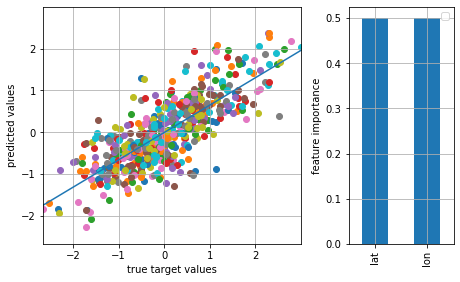

In [70]:
# Make a dictionary for all the X, y values
regressor_attributes = ['lat', 'lon']
feature_list_short = []
target='Q/P'
ynormal = True
X[target], y[target] = set_X_y(df, regressor_attributes, target, xnormal=True, ynormal=ynormal)

kf = KFold(n_splits=20, shuffle=True)
y_hat[target], rmse, r2, feature_importance = cross_val_rf(X[target],y[target],regressor_attributes,kf,
                ynormal=ynormal, n_estimators=1000,random_state=100,
                criterion='mse', min_samples_leaf=1, min_samples_split=2, max_depth=None,
                min_weight_fraction_leaf=0)

In [84]:
df['forest'] = df['tree_canopy_cover']
df['imperv'] = df['impervious']

/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Overall rmse for the out-of-sample predictions: 1.08
Overall r^2 for the out-of-sample predictions: 0.00
RMSE Value stats for cross validation
mean = 1.07,  median = 1.06, stdev = 0.16, min = 0.71, max = 1.32
R-squared Value stats for cross validation
mean = 0.04,  median = 0.02, stdev = 0.05, min = 0.00, max = 0.23


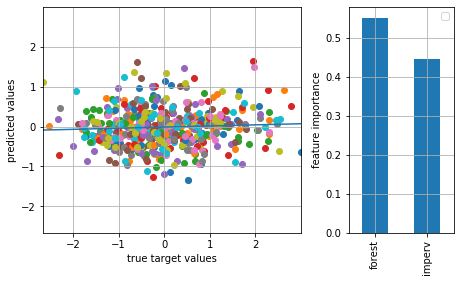

In [89]:
# Make a dictionary for all the X, y values
regressor_attributes = ['forest', 'imperv']
feature_list_short = []
target='Q/P'
ynormal = True
X[target], y[target] = set_X_y(df, regressor_attributes, target, xnormal=True, ynormal=ynormal)

kf = KFold(n_splits=20, shuffle=True)
y_hat[target], rmse, r2, feature_importance = cross_val_rf(X[target],y[target],regressor_attributes,kf,
                ynormal=ynormal, n_estimators=1000,random_state=100,
                criterion='mse', min_samples_leaf=1, min_samples_split=2, max_depth=None,
                min_weight_fraction_leaf=0)

In [87]:
df['evap'] = df['potential_evaporation']
df['skinT'] = df['skin_temperature']
df['soilT'] = df['soil_temperature_level_1']
df['trans'] = df['evaporation_from_vegetation_transpiration']

/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

Overall rmse for the out-of-sample predictions: 0.76
Overall r^2 for the out-of-sample predictions: 0.43
RMSE Value stats for cross validation
mean = 0.75,  median = 0.75, stdev = 0.12, min = 0.59, max = 1.08
R-squared Value stats for cross validation
mean = 0.45,  median = 0.45, stdev = 0.14, min = 0.20, max = 0.73


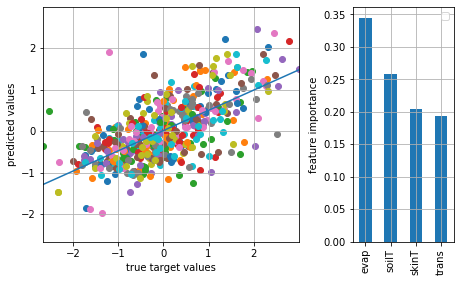

In [90]:
regressor_attributes = ['evap','skinT','soilT','trans']
feature_list_short = []
target='Q/P'
ynormal = True
X[target], y[target] = set_X_y(df, regressor_attributes, target, xnormal=True, ynormal=ynormal)

kf = KFold(n_splits=20, shuffle=True)
y_hat[target], rmse, r2, feature_importance = cross_val_rf(X[target],y[target],regressor_attributes,kf,
                ynormal=ynormal, n_estimators=1000,random_state=100,
                criterion='mse', min_samples_leaf=1, min_samples_split=2, max_depth=None,
                min_weight_fraction_leaf=0)